In [9]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale = 1.8)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 25

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn import Module
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from sklearn.model_selection import train_test_split

print('Python', sys.version)

Python 3.9.16 (main, Dec  7 2022, 18:33:36) 
[GCC 12.2.0]


In [3]:
class dalitz_dataset(Dataset):
    """
    Creates Dalitz dataset so that it can be used by the pythorch syntax.
    """

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample

In [4]:
class Linear_VB(Module):
    """
    Build a Bayesian linear weight layer i.e. weights are now distributions
    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor
    
    def __init__(self, in_features, out_features, resample = True):
        super(Linear_VB, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.resample = resample                                        # Sample random weights through each forward pass
        self.bias = Parameter(Tensor(out_features))                     # Assign as tunable parameter with dimension (1 x out_features)
        self.mu_w = Parameter(Tensor(out_features, in_features))        # Assign as tunable parameter with dimension (out_features x in_features)
        self.logsig2_w = Parameter(Tensor(out_features, in_features))   # Assign as tunable parameter with dimension (out_features x in_features)
        self.random = torch.randn_like(self.logsig2_w)
        self.reset_parameters()
        
    def forward( self, input ):
        # Sample random weights on each forward pass
        if self.resample:
            self.random = torch.randn_like(self.logsig2_w)
        s2_w = self.logsig2_w.exp()
        # Reparameterization trick
        weight = self.mu_w + s2_w.sqrt() * self.random
        return nn.functional.linear(input, weight, self.bias)
    
    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.mu_w.size(1))
        self.mu_w.data.normal_(0, stdv)
        self.logsig2_w.data.zero_().normal_(-9, 0.001)
        self.bias.data.zero_()
        
    def KL( self, loguniform=False ):
        kl = 0.5 * (self.mu_w.pow(2) + self.logsig2_w.exp() - self.logsig2_w - 1).sum()
        return kl

In [42]:
class Bayes_INN(Module):
    def __init__(self, n_dim, training_size, input_dim = 2000, hidden_dim = 2000, output_dim = 2000, resample = True):
        super(Bayes_INN, self).__init__()

        # Number of entries in the training dataset
        self.n_dim = n_dim
        
        # Loss function is dependent on the size of the training dataset
        self.training_size = training_size

        def subnet(input_dim, output_dim):

            # Two types of layers -> weight layers and activation layers the latter is not Bayesian
            self.subnet_bayes_layers = []
            self.subnet_layers       = []
    
            # Define the input layer
            linear_VB_layer = Linear_VB(input_dim, hidden_dim)#, resample = resample)
            self.subnet_bayes_layers.append(linear_VB_layer)
            self.subnet_layers.append(linear_VB_layer)
            self.subnet_layers.append(nn.ReLU())
    
            # If you want a more complex subnet, add more hidden layers
            linear_VB_layer = Linear_VB(hidden_dim, hidden_dim)
            self.subnet_bayes_layers.append(linear_VB_layer)
            self.subnet_layers.append(linear_VB_layer)
            self.subnet_layers.append(nn.ReLU())
    
            # Now for the final output layer
            linear_VB_layer = Linear_VB(hidden_dim, output_dim)#, resample = resample)
            self.subnet_bayes_layers.append(linear_VB_layer)
            self.subnet_layers.append(linear_VB_layer)
            # We don't need an activation layer for the output layer
    
            # The full model is a sequentiual net over the defined layers above
            return nn.Sequential(*self.subnet_layers)


        self.inn = Ff.SequenceINN(self.n_dim)
        for k in range(self.n_dim):
            self.inn.append(Fm.AllInOneBlock, subnet_constructor=subnet, permute_soft=True)
            #self.inn.append(Fm.GINCouplingBlock, subnet_constructor=subnet)

    # We need the KL from the Bayesian layers
    def KL(self):
        kl = 0
        for bayesian_layer in self.subnet_bayes_layers:
            kl += bayesian_layer.KL()
        return kl / self.training_size # Normalized to the training size? 

In [31]:
def inn_loss(z, ndim, log_jac_det):
    l = 0.5*torch.sum(z**2, 1) - log_jac_det
    l = l.mean() / ndim
    return l

In [32]:
def train(dataloader, model, optimizer, scheduler=None, ndim = 5):

    size = len(dataloader.dataset)
    model.train()

    for batch, X in enumerate(dataloader):
        # Pass through the network
        z, log_jac_det = model(X)
        
        loss_inn, loss_KL, loss = 0.0, 0.0, 0.0
        
        # Compute the KL loss for each of the Bayesian layers in the network
        for i in range(len(model.module_list)):
            for j in [0,2,4]:
                loss_KL += model.module_list[i].subnet[j].KL()
        loss_KL = loss_KL / size
        loss_KL = 0
        #print(loss_KL)
        #print(BINN.KL())

        # Get the batch loss
        loss_inn = inn_loss(z, ndim, log_jac_det)
        
        loss = loss_KL + loss_inn
        
        # Also need to include KL loss for tuning stochastic layer weights

        # Reset the gradients in the optimizer (see autograd tutorial in PyTorch docs)
        optimizer.zero_grad()

        # Compute gradients
        loss.backward()

        # Update the network weights
        optimizer.step()
        
        if scheduler != None:
            scheduler.step(loss)

        # Print the loss every 100 updates
        if batch % 100 == 0:
            print(f'Total loss: {loss:>8f} INN loss: {loss_inn:>8f} KL loss: {loss_KL:>8f} learning_rate: {optimizer.param_groups[0]["lr"]:>8f}')

In [34]:
mp_thetap = np.load('D_Kspipi_SDP_1e7.npy')

# Split data into train, validation
mp_thetap_train, mp_thetap_val = train_test_split(mp_thetap, test_size=0.2)

print("Training set size: ", mp_thetap_train.shape, "Validation set size: ", mp_thetap_val.shape)

# Convert into torch objects
mp_thetap_train = torch.Tensor(mp_thetap_train)
mp_thetap_val   = torch.Tensor(mp_thetap_val)

trainset = dalitz_dataset(mp_thetap_train)
valset   = dalitz_dataset(mp_thetap_val)

batch_size = 500

train_dataloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(valset, batch_size = batch_size, shuffle = True)

epochs = 50
learning_rate = 0.001

n_dim = mp_thetap.shape[1]
input_dim = 1           # One value of mp or thetap
hidden_dim = 50         # Subnetwork hidden layers
output_dim = 1          # One value out for generated mp or thetap
training_size = len(mp_thetap)
resample = False

# Define the model
BINN = Bayes_INN(n_dim = n_dim, training_size = training_size, input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, resample = resample)
model = BINN.inn

print("Model Architecture: ")
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode= 'min', factor = 0.9, patience = 50)
#scheduler = None

for t in tqdm(range(epochs), ncols = 100):
    train(train_dataloader, model, optimizer, scheduler, n_dim)
    
print("Done!")

Training set size:  (8000000, 2) Validation set size:  (2000000, 2)
Model Architecture: 
SequenceINN(
  (module_list): ModuleList(
    (0): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear_VB()
        (1): ReLU()
        (2): Linear_VB()
        (3): ReLU()
        (4): Linear_VB()
        (5): ReLU()
        (6): Linear_VB()
        (7): ReLU()
        (8): Linear_VB()
        (9): ReLU()
        (10): Linear_VB()
        (11): ReLU()
        (12): Linear_VB()
        (13): ReLU()
        (14): Linear_VB()
        (15): ReLU()
        (16): Linear_VB()
      )
    )
    (1): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear_VB()
        (1): ReLU()
        (2): Linear_VB()
        (3): ReLU()
        (4): Linear_VB()
        (5): ReLU()
        (6): Linear_VB()
        (7): ReLU()
        (8): Linear_VB()
        (9): ReLU()
        (10): Linear_VB()
      

  0%|                                                                        | 0/50 [00:00<?, ?it/s]

Total loss: 0.119573 INN loss: 0.119573 KL loss: 0.000000 learning_rate: 0.001000
Total loss: -0.658589 INN loss: -0.658589 KL loss: 0.000000 learning_rate: 0.001000
Total loss: -1.067847 INN loss: -1.067847 KL loss: 0.000000 learning_rate: 0.001000


  2%|█▎                                                              | 1/50 [01:04<52:59, 64.90s/it]

Total loss: -1.072098 INN loss: -1.072098 KL loss: 0.000000 learning_rate: 0.001000
Total loss: -1.082202 INN loss: -1.082202 KL loss: 0.000000 learning_rate: 0.000900
Total loss: -1.076532 INN loss: -1.076532 KL loss: 0.000000 learning_rate: 0.000810


  4%|██▌                                                             | 2/50 [02:10<52:03, 65.08s/it]

Total loss: -1.079650 INN loss: -1.079650 KL loss: 0.000000 learning_rate: 0.000810
Total loss: -1.102931 INN loss: -1.102931 KL loss: 0.000000 learning_rate: 0.000810
Total loss: -1.075770 INN loss: -1.075770 KL loss: 0.000000 learning_rate: 0.000729


  6%|███▊                                                            | 3/50 [03:15<51:05, 65.23s/it]

Total loss: -1.143180 INN loss: -1.143180 KL loss: 0.000000 learning_rate: 0.000729
Total loss: -1.154045 INN loss: -1.154045 KL loss: 0.000000 learning_rate: 0.000729
Total loss: -1.155236 INN loss: -1.155236 KL loss: 0.000000 learning_rate: 0.000656


  8%|█████                                                           | 4/50 [04:21<50:22, 65.71s/it]

Total loss: -1.174161 INN loss: -1.174161 KL loss: 0.000000 learning_rate: 0.000590
Total loss: -1.206302 INN loss: -1.206302 KL loss: 0.000000 learning_rate: 0.000590
Total loss: -1.224656 INN loss: -1.224656 KL loss: 0.000000 learning_rate: 0.000531


 10%|██████▍                                                         | 5/50 [05:27<49:21, 65.81s/it]

Total loss: -1.226088 INN loss: -1.226088 KL loss: 0.000000 learning_rate: 0.000531
Total loss: -1.241771 INN loss: -1.241771 KL loss: 0.000000 learning_rate: 0.000531
Total loss: -1.233739 INN loss: -1.233739 KL loss: 0.000000 learning_rate: 0.000478


 12%|███████▋                                                        | 6/50 [06:33<48:09, 65.67s/it]

Total loss: -1.219333 INN loss: -1.219333 KL loss: 0.000000 learning_rate: 0.000387
Total loss: -1.246471 INN loss: -1.246471 KL loss: 0.000000 learning_rate: 0.000349
Total loss: -1.209271 INN loss: -1.209271 KL loss: 0.000000 learning_rate: 0.000314


 14%|████████▉                                                       | 7/50 [07:39<47:05, 65.71s/it]

Total loss: -1.231042 INN loss: -1.231042 KL loss: 0.000000 learning_rate: 0.000282
Total loss: -1.257079 INN loss: -1.257079 KL loss: 0.000000 learning_rate: 0.000229
Total loss: -1.254781 INN loss: -1.254781 KL loss: 0.000000 learning_rate: 0.000185


 16%|██████████▏                                                     | 8/50 [08:44<45:57, 65.66s/it]

Total loss: -1.228588 INN loss: -1.228588 KL loss: 0.000000 learning_rate: 0.000185
Total loss: -1.251087 INN loss: -1.251087 KL loss: 0.000000 learning_rate: 0.000150
Total loss: -1.259428 INN loss: -1.259428 KL loss: 0.000000 learning_rate: 0.000122


 18%|███████████▌                                                    | 9/50 [09:50<44:48, 65.57s/it]

Total loss: -1.260670 INN loss: -1.260670 KL loss: 0.000000 learning_rate: 0.000109
Total loss: -1.249605 INN loss: -1.249605 KL loss: 0.000000 learning_rate: 0.000098
Total loss: -1.222480 INN loss: -1.222480 KL loss: 0.000000 learning_rate: 0.000080


 20%|████████████▌                                                  | 10/50 [10:54<43:33, 65.34s/it]

Total loss: -1.254829 INN loss: -1.254829 KL loss: 0.000000 learning_rate: 0.000080
Total loss: -1.251410 INN loss: -1.251410 KL loss: 0.000000 learning_rate: 0.000065
Total loss: -1.236286 INN loss: -1.236286 KL loss: 0.000000 learning_rate: 0.000052


 22%|█████████████▊                                                 | 11/50 [11:59<42:16, 65.04s/it]

Total loss: -1.248684 INN loss: -1.248684 KL loss: 0.000000 learning_rate: 0.000042
Total loss: -1.253682 INN loss: -1.253682 KL loss: 0.000000 learning_rate: 0.000038
Total loss: -1.259559 INN loss: -1.259559 KL loss: 0.000000 learning_rate: 0.000031


 24%|███████████████                                                | 12/50 [13:04<41:12, 65.06s/it]

Total loss: -1.258943 INN loss: -1.258943 KL loss: 0.000000 learning_rate: 0.000028
Total loss: -1.258250 INN loss: -1.258250 KL loss: 0.000000 learning_rate: 0.000023
Total loss: -1.267631 INN loss: -1.267631 KL loss: 0.000000 learning_rate: 0.000018


 26%|████████████████▍                                              | 13/50 [14:08<39:59, 64.86s/it]

Total loss: -1.246804 INN loss: -1.246804 KL loss: 0.000000 learning_rate: 0.000016
Total loss: -1.252677 INN loss: -1.252677 KL loss: 0.000000 learning_rate: 0.000013
Total loss: -1.209268 INN loss: -1.209268 KL loss: 0.000000 learning_rate: 0.000011


 28%|█████████████████▋                                             | 14/50 [15:13<38:49, 64.70s/it]

Total loss: -1.247992 INN loss: -1.247992 KL loss: 0.000000 learning_rate: 0.000010
Total loss: -1.262013 INN loss: -1.262013 KL loss: 0.000000 learning_rate: 0.000008
Total loss: -1.257139 INN loss: -1.257139 KL loss: 0.000000 learning_rate: 0.000006


 30%|██████████████████▉                                            | 15/50 [16:17<37:42, 64.64s/it]

Total loss: -1.258397 INN loss: -1.258397 KL loss: 0.000000 learning_rate: 0.000006
Total loss: -1.267675 INN loss: -1.267675 KL loss: 0.000000 learning_rate: 0.000005
Total loss: -1.264576 INN loss: -1.264576 KL loss: 0.000000 learning_rate: 0.000004


 32%|████████████████████▏                                          | 16/50 [17:22<36:36, 64.61s/it]

Total loss: -1.254364 INN loss: -1.254364 KL loss: 0.000000 learning_rate: 0.000003
Total loss: -1.258979 INN loss: -1.258979 KL loss: 0.000000 learning_rate: 0.000003
Total loss: -1.245959 INN loss: -1.245959 KL loss: 0.000000 learning_rate: 0.000002


 34%|█████████████████████▍                                         | 17/50 [18:26<35:29, 64.54s/it]

Total loss: -1.243761 INN loss: -1.243761 KL loss: 0.000000 learning_rate: 0.000002
Total loss: -1.228068 INN loss: -1.228068 KL loss: 0.000000 learning_rate: 0.000002
Total loss: -1.246197 INN loss: -1.246197 KL loss: 0.000000 learning_rate: 0.000001


 36%|██████████████████████▋                                        | 18/50 [19:30<34:22, 64.46s/it]

Total loss: -1.249908 INN loss: -1.249908 KL loss: 0.000000 learning_rate: 0.000001
Total loss: -1.249110 INN loss: -1.249110 KL loss: 0.000000 learning_rate: 0.000001
Total loss: -1.250468 INN loss: -1.250468 KL loss: 0.000000 learning_rate: 0.000001


 38%|███████████████████████▉                                       | 19/50 [20:35<33:16, 64.42s/it]

Total loss: -1.247541 INN loss: -1.247541 KL loss: 0.000000 learning_rate: 0.000001
Total loss: -1.226574 INN loss: -1.226574 KL loss: 0.000000 learning_rate: 0.000001
Total loss: -1.264475 INN loss: -1.264475 KL loss: 0.000000 learning_rate: 0.000000


 40%|█████████████████████████▏                                     | 20/50 [21:39<32:12, 64.43s/it]

Total loss: -1.231829 INN loss: -1.231829 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.228818 INN loss: -1.228818 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.257904 INN loss: -1.257904 KL loss: 0.000000 learning_rate: 0.000000


 42%|██████████████████████████▍                                    | 21/50 [22:44<31:08, 64.45s/it]

Total loss: -1.264367 INN loss: -1.264367 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.254395 INN loss: -1.254395 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.260635 INN loss: -1.260635 KL loss: 0.000000 learning_rate: 0.000000


 44%|███████████████████████████▋                                   | 22/50 [23:48<30:03, 64.39s/it]

Total loss: -1.233529 INN loss: -1.233529 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.259243 INN loss: -1.259243 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.243227 INN loss: -1.243227 KL loss: 0.000000 learning_rate: 0.000000


 46%|████████████████████████████▉                                  | 23/50 [24:52<28:59, 64.44s/it]

Total loss: -1.224600 INN loss: -1.224600 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.254652 INN loss: -1.254652 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.263231 INN loss: -1.263231 KL loss: 0.000000 learning_rate: 0.000000


 48%|██████████████████████████████▏                                | 24/50 [25:57<27:53, 64.37s/it]

Total loss: -1.266406 INN loss: -1.266406 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.258259 INN loss: -1.258259 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.258490 INN loss: -1.258490 KL loss: 0.000000 learning_rate: 0.000000


 50%|███████████████████████████████▌                               | 25/50 [27:01<26:48, 64.34s/it]

Total loss: -1.265311 INN loss: -1.265311 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.252546 INN loss: -1.252546 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.258132 INN loss: -1.258132 KL loss: 0.000000 learning_rate: 0.000000


 52%|████████████████████████████████▊                              | 26/50 [28:05<25:43, 64.29s/it]

Total loss: -1.245931 INN loss: -1.245931 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.253406 INN loss: -1.253406 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.253884 INN loss: -1.253884 KL loss: 0.000000 learning_rate: 0.000000


 54%|██████████████████████████████████                             | 27/50 [29:09<24:38, 64.28s/it]

Total loss: -1.262383 INN loss: -1.262383 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.264262 INN loss: -1.264262 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.261795 INN loss: -1.261795 KL loss: 0.000000 learning_rate: 0.000000


 56%|███████████████████████████████████▎                           | 28/50 [30:13<23:33, 64.25s/it]

Total loss: -1.262519 INN loss: -1.262519 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.247670 INN loss: -1.247670 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.248601 INN loss: -1.248601 KL loss: 0.000000 learning_rate: 0.000000


 58%|████████████████████████████████████▌                          | 29/50 [31:18<22:28, 64.21s/it]

Total loss: -1.255621 INN loss: -1.255621 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.260129 INN loss: -1.260129 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.244927 INN loss: -1.244927 KL loss: 0.000000 learning_rate: 0.000000


 60%|█████████████████████████████████████▊                         | 30/50 [32:22<21:24, 64.22s/it]

Total loss: -1.262866 INN loss: -1.262866 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.249980 INN loss: -1.249980 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.259260 INN loss: -1.259260 KL loss: 0.000000 learning_rate: 0.000000


 62%|███████████████████████████████████████                        | 31/50 [33:26<20:21, 64.27s/it]

Total loss: -1.232393 INN loss: -1.232393 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.266929 INN loss: -1.266929 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.242610 INN loss: -1.242610 KL loss: 0.000000 learning_rate: 0.000000


 64%|████████████████████████████████████████▎                      | 32/50 [34:31<19:22, 64.58s/it]

Total loss: -1.266184 INN loss: -1.266184 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.262491 INN loss: -1.262491 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.254281 INN loss: -1.254281 KL loss: 0.000000 learning_rate: 0.000000


 66%|█████████████████████████████████████████▌                     | 33/50 [35:36<18:19, 64.67s/it]

Total loss: -1.260024 INN loss: -1.260024 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.254348 INN loss: -1.254348 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.246904 INN loss: -1.246904 KL loss: 0.000000 learning_rate: 0.000000


 68%|██████████████████████████████████████████▊                    | 34/50 [36:41<17:12, 64.56s/it]

Total loss: -1.249040 INN loss: -1.249040 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.251972 INN loss: -1.251972 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.252003 INN loss: -1.252003 KL loss: 0.000000 learning_rate: 0.000000


 70%|████████████████████████████████████████████                   | 35/50 [37:46<16:09, 64.66s/it]

Total loss: -1.267803 INN loss: -1.267803 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.242948 INN loss: -1.242948 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.254328 INN loss: -1.254328 KL loss: 0.000000 learning_rate: 0.000000


 72%|█████████████████████████████████████████████▎                 | 36/50 [38:50<15:04, 64.61s/it]

Total loss: -1.237213 INN loss: -1.237213 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.243837 INN loss: -1.243837 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.257562 INN loss: -1.257562 KL loss: 0.000000 learning_rate: 0.000000


 74%|██████████████████████████████████████████████▌                | 37/50 [39:55<13:59, 64.57s/it]

Total loss: -1.248376 INN loss: -1.248376 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.258310 INN loss: -1.258310 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.252499 INN loss: -1.252499 KL loss: 0.000000 learning_rate: 0.000000


 76%|███████████████████████████████████████████████▉               | 38/50 [40:59<12:54, 64.51s/it]

Total loss: -1.264734 INN loss: -1.264734 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.250006 INN loss: -1.250006 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.248438 INN loss: -1.248438 KL loss: 0.000000 learning_rate: 0.000000


 78%|█████████████████████████████████████████████████▏             | 39/50 [42:03<11:49, 64.46s/it]

Total loss: -1.254530 INN loss: -1.254530 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.263370 INN loss: -1.263370 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.253599 INN loss: -1.253599 KL loss: 0.000000 learning_rate: 0.000000


 80%|██████████████████████████████████████████████████▍            | 40/50 [43:08<10:45, 64.58s/it]

Total loss: -1.254966 INN loss: -1.254966 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.260389 INN loss: -1.260389 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.256768 INN loss: -1.256768 KL loss: 0.000000 learning_rate: 0.000000


 82%|███████████████████████████████████████████████████▋           | 41/50 [44:12<09:40, 64.47s/it]

Total loss: -1.260969 INN loss: -1.260969 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.254908 INN loss: -1.254908 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.232531 INN loss: -1.232531 KL loss: 0.000000 learning_rate: 0.000000


 84%|████████████████████████████████████████████████████▉          | 42/50 [45:17<08:35, 64.41s/it]

Total loss: -1.258647 INN loss: -1.258647 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.235772 INN loss: -1.235772 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.240887 INN loss: -1.240887 KL loss: 0.000000 learning_rate: 0.000000


 86%|██████████████████████████████████████████████████████▏        | 43/50 [46:21<07:30, 64.34s/it]

Total loss: -1.246428 INN loss: -1.246428 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.252312 INN loss: -1.252312 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.244120 INN loss: -1.244120 KL loss: 0.000000 learning_rate: 0.000000


 88%|███████████████████████████████████████████████████████▍       | 44/50 [47:25<06:26, 64.41s/it]

Total loss: -1.246179 INN loss: -1.246179 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.251730 INN loss: -1.251730 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.254380 INN loss: -1.254380 KL loss: 0.000000 learning_rate: 0.000000


 90%|████████████████████████████████████████████████████████▋      | 45/50 [48:30<05:22, 64.41s/it]

Total loss: -1.259015 INN loss: -1.259015 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.250650 INN loss: -1.250650 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.249808 INN loss: -1.249808 KL loss: 0.000000 learning_rate: 0.000000


 92%|█████████████████████████████████████████████████████████▉     | 46/50 [49:34<04:17, 64.39s/it]

Total loss: -1.253009 INN loss: -1.253009 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.242374 INN loss: -1.242374 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.241945 INN loss: -1.241945 KL loss: 0.000000 learning_rate: 0.000000


 94%|███████████████████████████████████████████████████████████▏   | 47/50 [50:38<03:13, 64.39s/it]

Total loss: -1.248397 INN loss: -1.248397 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.246755 INN loss: -1.246755 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.261129 INN loss: -1.261129 KL loss: 0.000000 learning_rate: 0.000000


 96%|████████████████████████████████████████████████████████████▍  | 48/50 [51:43<02:08, 64.35s/it]

Total loss: -1.260915 INN loss: -1.260915 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.247028 INN loss: -1.247028 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.260213 INN loss: -1.260213 KL loss: 0.000000 learning_rate: 0.000000


 98%|█████████████████████████████████████████████████████████████▋ | 49/50 [52:47<01:04, 64.36s/it]

Total loss: -1.221119 INN loss: -1.221119 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.258139 INN loss: -1.258139 KL loss: 0.000000 learning_rate: 0.000000
Total loss: -1.262241 INN loss: -1.262241 KL loss: 0.000000 learning_rate: 0.000000


100%|███████████████████████████████████████████████████████████████| 50/50 [53:51<00:00, 64.64s/it]

Done!


torch.Size([100000, 2])


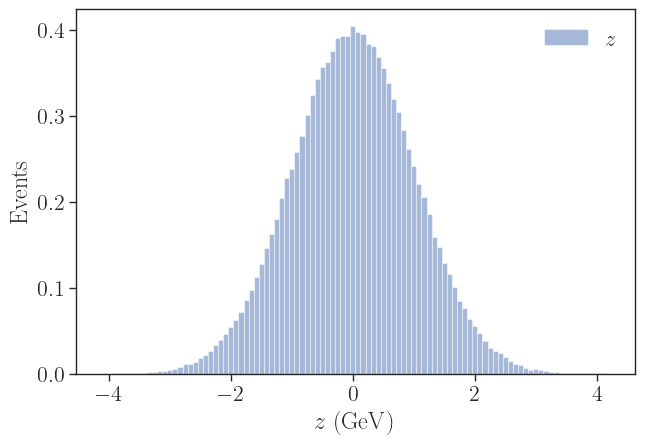

In [35]:
# Latent distribution
n_samples = 100000
z_gen = torch.randn((n_samples, n_dim))

print(z_gen.shape)

# Visualize the latent distribution
fig, axs = plt.subplots(figsize=(7,5))

axs.hist(z_gen.detach().numpy().flatten(), alpha=0.5, density=True, bins=100, label=r'$z$')

axs.set_xlabel('$z$ $(\mathrm{GeV})$')
axs.set_ylabel( r'$\mathrm{Events}$' )
axs.legend(loc='best', frameon=False)

fig.tight_layout()

In [36]:
# Generate m2 samples from latent distribution
mp_thetap_gen, _ = model(z_gen, rev=True)
mp_thetap_gen = mp_thetap_gen.detach().numpy()[:]

print(mp_thetap_gen.shape)
print(mp_thetap_gen[0])

(100000, 2)
[0.63677406 0.02960048]


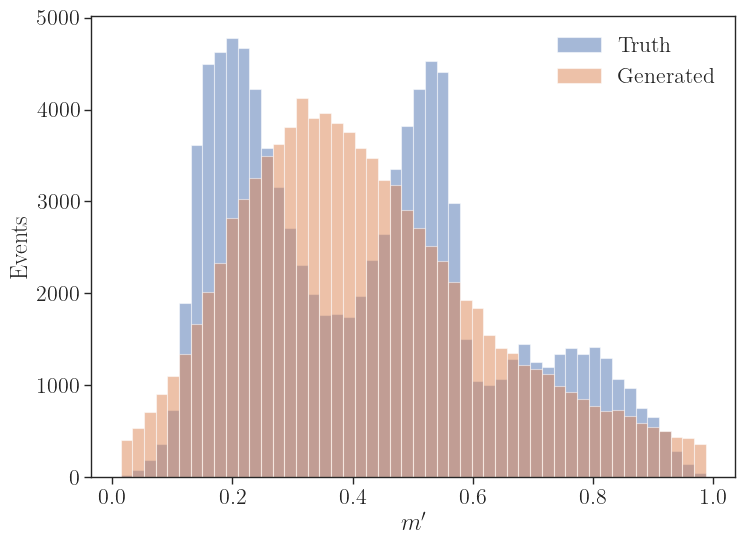

In [41]:
# Visualize 
fig, ax = plt.subplots( figsize=(8,6) )

counts, bins, _ = ax.hist(mp_thetap[:n_samples,0], 50, alpha = 0.5, label = r'$\mathrm{Truth}$')
ax.hist(mp_thetap_gen[:,0], bins, alpha=0.5, label = r'$\mathrm{Generated}$')

ax.set_xlabel( r"$m'$")
ax.set_ylabel( r'$\mathrm{Events}$' )


ax.legend(loc='best', frameon=False)

fig.tight_layout()

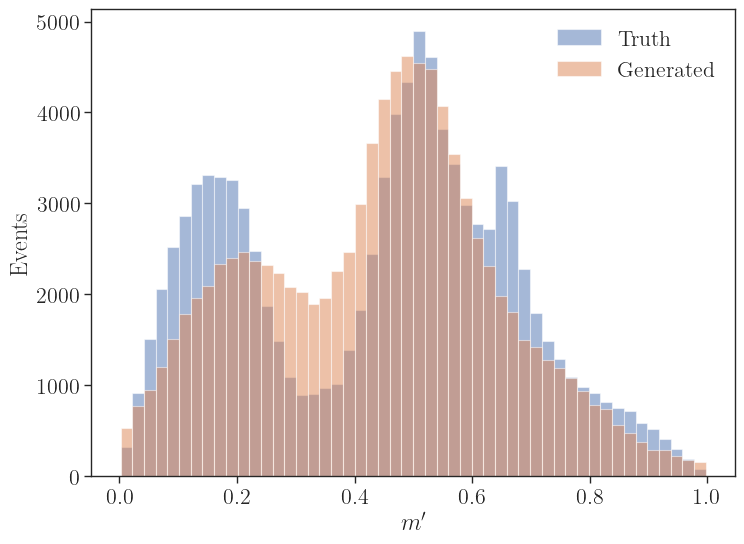

In [40]:
# Visualize 
fig, ax = plt.subplots( figsize=(8,6) )

counts, bins, _ = ax.hist(mp_thetap[:n_samples,1], 50, alpha = 0.5, label = r'$\mathrm{Truth}$')
ax.hist(mp_thetap_gen[:,1], bins, alpha=0.5, label = r'$\mathrm{Generated}$')

ax.set_xlabel( r"$m'$")
ax.set_ylabel( r'$\mathrm{Events}$' )


ax.legend(loc='best', frameon=False)

fig.tight_layout()